In [129]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [130]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import time

plt.style.use(FIG_ROOT/"base.mplstyle")

In [131]:
from utils.misc import load_txt

In [132]:
import re

def extract_losses(text, is_base=True):
    train_losses = []
    test_losses = []

    for line in text:
        if line.strip() == '':
            continue
        
        tmp = re.search(r'iter (\d+)', line)
        if tmp is not None:
            iter_num = int(re.search(r'iter (\d+)', line).group(1))
            loss = float(re.search(r'the losses are (\d+\.\d+)', line).group(1))
            if is_base:
                loss_base = float(re.search(r'the base losses are (\d+\.\d+)', line).group(1))
            iter_num_perepoch = int(re.search(r'/(\d+),', line).group(1))
            epoch_num = int(re.search(r'epoch (\d+),', line).group(1))
        
            if 'train' in line:
                if is_base:
                    train_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss, loss_base))
                else:
                    train_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss))
            elif 'test' in line:
                if is_base:
                    test_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss, loss_base))
                else:
                    test_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss))

    return np.array(train_losses), np.array(test_losses)

def moving_median(data, window_size):
    if window_size < 1 or not isinstance(window_size, int):
        raise ValueError("Window size must be a positive integer")

    if len(data) < window_size:
        raise ValueError("Window size must be smaller than or equal to the length of the data")

    result = []
    for i in range(len(data) - window_size + 1):
        result.append(np.median(data[i:i + window_size]))
    return np.array(result)

In [133]:
fil_path = RES_ROOT/"../bash_scripts/logs/EEG_lay2_dis_10step_latent_intervalbds_nomodel.out"
txt_content = load_txt(fil_path);
txt_content[-10:]

['At iter 20000/65582, epoch 3, the losses are 4.229 (test). the base losses are 104.377 (test). \n',
 'Adjusting learning rate of group 0 to 1.0000e-07.\n',
 '/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/bash_scripts/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_model_epoch3\n',
 'Create a folder /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/bash_scripts/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_model_epoch3\n',
 'Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/bash_scripts/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_model_epoch3/model.pkl\n',
 'Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/bash_scripts/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_model_epoch3/config.pkl\n',
 'Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/bash_scripts/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_model_epoch3/loss_fn.pkl\n',
 'Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/bash_scripts/../mypkg/../results/Lay

In [134]:
tr_losses, te_losses = extract_losses(txt_content, True)

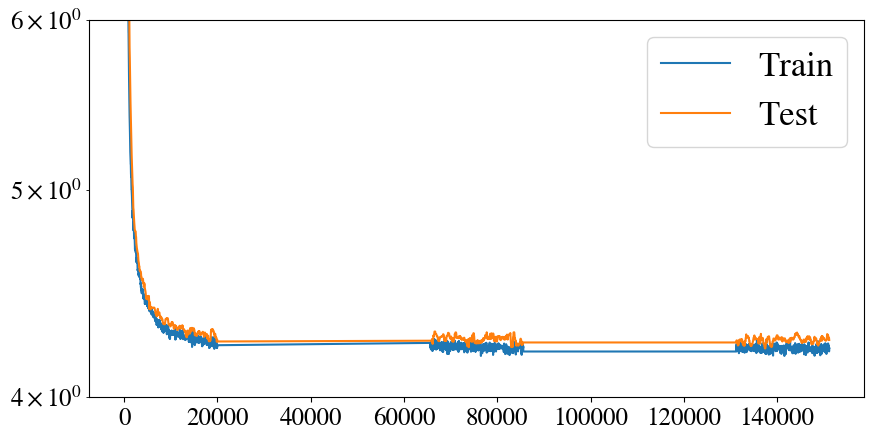

In [135]:
win_size = 10
plt.plot(tr_losses[(win_size-1):, 0], moving_median(tr_losses[:, 1], win_size), label="Train")
plt.plot(te_losses[(win_size-1):, 0], moving_median(te_losses[:, 1], win_size), label="Test")
#plt.plot(tr_losses[(win_size-1):, 0], moving_median(tr_losses[:, 2], win_size), label="Train-base")
#plt.plot(te_losses[(win_size-1):, 0], moving_median(te_losses[:, 2], win_size), label="Test-base")
plt.yscale("log")
plt.ylim([4, 6])
plt.legend()